In [27]:
import os.path
import sys
import logging
import csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import sklearn.svm
import sklearn.linear_model
import sklearn.ensemble
import sklearn.pipeline

sys.path.append("../../")  # trick to import clairvoya from internal notebook directory
import clairvoya.runbench
import clairvoya.pulearning
import clairvoya.voya_plotter
import clairvoya.datasetup
import cPickle as pickle

%matplotlib inline

voya_logger = logging.getLogger('voya_notebook')
voya_logger.setLevel(logging.INFO)
fh = logging.FileHandler('voya_notebook.log')
fh.setLevel(logging.DEBUG)
voya_logger.addHandler(fh)
logging.getLogger('clairvoya').addHandler(fh)

# Setup

In [16]:
df = pd.read_csv('../data/test1_uni_f.csv')
df.head()

,cid,label,cid/tech/ecommerce,url/tech/traffic_rank,url/tech/conversion_tracking,url/tech/html_ids,url/tech/html_classes,url/tech/login,url/tech/platform_count,url/tech/subscribe,url/tech/univ_analytics,url/tech/tech_sum,url/tech/likes,url/tech/feedback,url/tech/analytics_count,url/tech/video_count,url/tech/mobile_aware
0,899001,1,1,4.550876,0,1.672098,2.296665,1,6,1,0,1,5.264343,0,1,0,0
1,1703999,1,0,7.154740,0,0.477121,1.204120,0,0,0,0,1,0.000000,0,0,0,0
2,2247971,1,0,6.422567,0,2.053078,1.477121,1,0,0,0,0,0.000000,0,1,0,0
3,308163,1,0,6.796991,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0,0,0
4,1935839,1,0,6.796991,0,1.000000,1.000000,0,0,0,0,0,0.000000,0,0,0,0


In [17]:
df.describe()

,cid,label,cid/tech/ecommerce,url/tech/traffic_rank,url/tech/conversion_tracking,url/tech/html_ids,url/tech/html_classes,url/tech/login,url/tech/platform_count,url/tech/subscribe,url/tech/univ_analytics,url/tech/tech_sum,url/tech/likes,url/tech/feedback,url/tech/analytics_count,url/tech/video_count,url/tech/mobile_aware
count,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000,909495.000000
mean,1696254.783314,-0.003236,0.046376,6.753796,0.016050,0.704951,0.796215,0.167617,0.578420,0.051359,0.078383,0.416460,0.385278,0.001360,0.036306,0.036989,0.211666
std,997505.191129,0.068772,0.210299,0.331563,0.196548,0.703598,0.796143,0.373526,1.194542,0.220730,0.268774,0.492972,1.028116,0.036854,0.204897,0.195566,0.479409
min,3.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,877386.500000,0.000000,0.000000,6.796991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1716996.000000,0.000000,0.000000,6.796991,0.000000,0.698970,0.698970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2349450.000000,0.000000,0.000000,6.796991,0.000000,1.322219,1.544068,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4289281.000000,1.000000,1.000000,7.406857,127.000000,3.741782,3.625827,1.000000,8.000000,1.000000,1.000000,1.000000,7.973324,1.000000,4.000000,3.000000,2.000000


In [18]:
num_labels = pd.value_counts(df[['label']].values.ravel())  # numbers in each group
print num_labels
num_pos = num_labels[1]
num_neg = num_labels[-1]
num_unl = num_labels[0]

 0    905184
-1      3627
 1       684
dtype: int64


In [19]:
df_pos_neg = df[df['label'] != 0]
df_unlab = df[df['label'] == 0]

In [20]:
def generate_mixed_df(unlab_to_pos_frac):
    df_unlab.reindex(np.random.permutation(df_unlab.index))
    num_required_unlab = int(num_pos * unlab_to_pos_frac)
    mixed_df = df_pos_neg.append(df_unlab[:num_required_unlab], ignore_index=True)
    return mixed_df

# Configuring the benchmark

In [34]:
# Classifiers
LR_estimator = sklearn.linear_model.LogisticRegression()
svm_estimator = sklearn.svm.SVC()

LRPosOnly = sklearn.pipeline.Pipeline([
    ('lr' , LR_estimator),
    ('po', clairvoya.pulearning.PosOnly(LR_estimator)),
])

SVMPosOnly = sklearn.pipeline.Pipeline([
    ('svm' , svm_estimator),
    ('po', clairvoya.pulearning.PosOnly(svm_estimator)),
])

SVMDoubleWeight = sklearn.pipeline.Pipeline([
    ('svm' , svm_estimator),
    ('dw', clairvoya.pulearning.PULearnByDoubleWeighting(svm_estimator)),
])

LRDoubleWeight = sklearn.pipeline.Pipeline([
    ('lr' , LR_estimator),
    ('dw', clairvoya.pulearning.PULearnByDoubleWeighting(LR_estimator)),
])

In [35]:
save_file = 'result_data/test1_results.csv'
num_runs_per = 10
unlab_to_pos_range = (0.2, 0.5, 1, 5, 10, 30, 50)

config = {
    "out_path": None,
    "num_cores": 3,
    "verbosity": 0,
    "pu_learning": True,
}

classifiers = {
    # Bagging eventually breaks with too many open files error
#     'LR_Bagging': clairvoya.pulearning.PUBagging(LR_estimator, n_estimators=50, max_samples=0.5,),
#     'SVM_Bagging': clairvoya.pulearning.PUBagging(svc_estimator, n_estimators=50, max_samples=0.5,),
    # PU
    'LR_PosOnly(E&N2008)': LRPosOnly,
#     'SVM_PosOnly(E&N2008)': SVMPosOnly,  # Cant predict proba

#     'SVM_DoubleWeight(E&N2008)': SVMDoubleWeight,
#     'LR_DoubleWeight(E&N2008)': LRDoubleWeight,  # fit() got an unexpected keyword argument 'sample_weight'
    
    # Normal
    'Logistic Regression': sklearn.linear_model.LogisticRegression(),
    'Gradient Boosting': sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2),
    'Random Forest': sklearn.ensemble.RandomForestClassifier(n_jobs=config["num_cores"]),
}

classifiers_gridparameters = { # Gridsearch off
#     'LR_Bagging': {'po__n_estimators': [30, 100], 'po__max_samples': [0.1, 0.3, 0.7, 1.0],
#                    'lr__fit_intercept': [True, False], 'lr__C': [0.1, 0.3, 0.7, 1.0],}
    'LSVM_PosOnly(E&N2008)' : {'po__hold_out_ratio': [0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
                               'svm__C': [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0]},
    
    'LR_PosOnly(E&N2008)': {'po__hold_out_ratio': [0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
                           'lr__fit_intercept': [True], 'lr__C': [0.1, 0.3, 0.5, 0.7, 1.0]},

    'LSVM_DoubleWeight(E&N2008)': {'svm__C': [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0]},
    'LR_DoubleWeight(E&N2008)': {'lr__fit_intercept': [True], 'lr__C': [0.1, 0.3, 0.5, 0.7, 1.0]},

    'Logistic Regression': {'fit_intercept': [True], 'C': [0.1, 0.3, 0.5, 0.7, 1.0]},
    'Gradient Boosting': {"n_estimators": [10, 30, 50, 70, 100], 'learning_rate': [0.1, 0.3, 0.7, 1.0],
                          'max_depth': [1, 2, 3, 4, 5, 7, 10]},

    'Random Forest': {"n_estimators": [10, 30, 50, 70, 100], 'max_depth': [1, 2, 3, 4, 5, 7, 10]},
}

## Now run it

In [ ]:
if not os.path.exists(save_file):
    with open(save_file, 'wb') as f:
        f.write('clf,auc,gamma\n')

gamma_range = unlab_to_pos_range
auc_results = {clf_name:[] for clf_name in classifiers.keys()}
for g_num, gamma in enumerate(gamma_range):
    voya_logger.info('Running classifiers for gamma={} ({}/{})'.format(gamma, g_num, len(gamma_range)))
    run_results = {clf_name:[] for clf_name in classifiers.keys()}
    for i in xrange(num_runs_per):
        mixed_df = generate_mixed_df(gamma)
        config.update({"data_file":  mixed_df})

        results_dict = clairvoya.runbench.run_benchmark(config, classifiers, classifiers_gridparameters)
        
        # Output
        csv_output = []
        for clf_name in classifiers.keys():
            csv_output.append((clf_name, results_dict[clf_name]['auc_score'], gamma))
            
        with open(save_file, 'ab') as f:
            csv_f = csv.writer(f)
            csv_f.writerows(csv_output)
            
    for clf_name in classifiers.keys():
        auc_results[clf_name].append(run_results[clf_name])

INFO:voya_notebook:Running classifiers for gamma=0.2 (0/7)
INFO:voya_notebook:Running classifiers for gamma=0.5 (1/7)
INFO:voya_notebook:Running classifiers for gamma=1 (2/7)
INFO:voya_notebook:Running classifiers for gamma=5 (3/7)
INFO:voya_notebook:Running classifiers for gamma=10 (4/7)
INFO:voya_notebook:Running classifiers for gamma=30 (5/7)
/Users/ryan/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
INFO:voya_notebook:Running classifiers for gamma=50 (6/7)


## plots

In [30]:
results_df = pd.read_csv(save_file)
results_table = results_df.groupby(["clf", "gamma"], as_index=False).agg(['mean', 'std', 'count'])

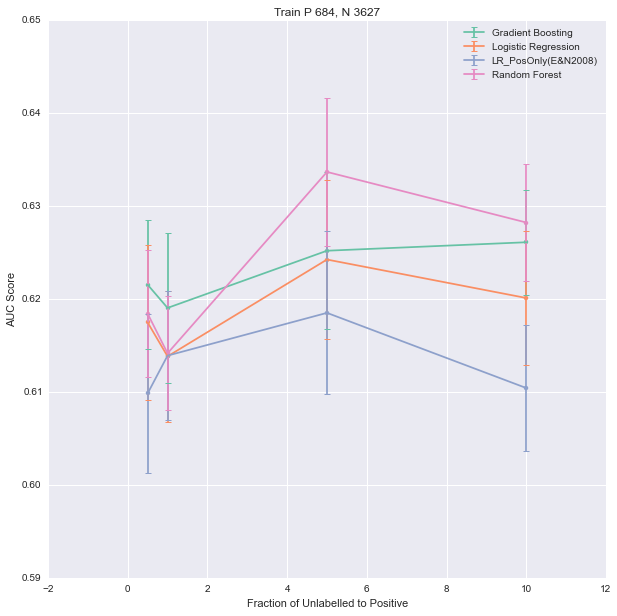

In [33]:
colors = seaborn.color_palette("Set2", 10)
result_classifiers = results_df.clf.unique()

plt.figure(figsize=(10,10))
for i, clf_name in enumerate(result_classifiers):
    clf_results = results_table.ix[(clf_name)]
    clf_gamma_range = clf_results.index
    auc_mean = clf_results.auc["mean"]
    auc_std = clf_results.auc["std"]
    auc_count = clf_results.auc["count"]
    auc_std_err = auc_std / np.sqrt(auc_count)
    
    plt.errorbar(clf_gamma_range, auc_mean, yerr=auc_std_err, label=clf_name,
                 c=colors[i], capthick=1)
    plt.scatter(clf_gamma_range, auc_mean, c=colors[i], lw=0)
    
    plt.ylabel('AUC Score')
    plt.xlabel('Fraction of Unlabelled to Positive')
    plt.legend()
    
    title = "Train P {}, N {}".format(
        num_pos, num_neg)
    plt.title(title)
    plt.savefig(title + '.png')